In [1]:
from mamba_ssm import Mamba2
import torch
from mamba_ssm.utils.generation import InferenceParams 
import pandas as pd

/anaconda/envs/mamba_custom/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:

batch, length, dim = 20, 5, 16
x = torch.randn(batch, length, dim).to("cuda")
model = Mamba2(
    # This module uses roughly 3 * expand * d_model^2 parameters
    d_model=dim,  # Model dimension d_model
    d_state=128,  # SSM state expansion factor
    d_conv=4,  # Local convolution width
    expand=8,  # Block expansion factor
    headdim=16,
    layer_idx=0,
).to("cuda")

model.eval()

# warmup the model
model(x)

# Training-style forward pass (full sequence in parallel)
start = torch.cuda.Event(enable_timing=True)
end = torch.cuda.Event(enable_timing=True)
start.record()
y1 = model(x)
end.record()
torch.cuda.synchronize()
print('y1', start.elapsed_time(end))  # prints time in milliseconds
assert y1.shape == x.shape

# Inference-style forward pass (full sequence in parallel)
start = torch.cuda.Event(enable_timing=True)
end = torch.cuda.Event(enable_timing=True)
start.record()
infer_params = InferenceParams(max_batch_size=batch, max_seqlen=length)
y2 = model(x, inference_params=infer_params)
end.record()
torch.cuda.synchronize()
print('y2', start.elapsed_time(end))  # prints time in milliseconds

# Inference-style forward pass (step by step using for loop)
start = torch.cuda.Event(enable_timing=True)
end = torch.cuda.Event(enable_timing=True)
start.record()
infer_params = InferenceParams(max_batch_size=batch, max_seqlen=length)
outs = []
for i in range(length):
    out = model(x[:, i : i + 1, :], inference_params=infer_params)
    infer_params.seqlen_offset += 1
    outs.append(out)
y3 = torch.cat(outs, 1)
end.record()
torch.cuda.synchronize()
print('y3', start.elapsed_time(end))  # prints time in milliseconds

print(torch.allclose(y1, y2))  # prints True
print(torch.allclose(y2, y3))  # prints False
print(torch.allclose(y1, y3))  # prints False

y1 1.8380800485610962
y2 5.676032066345215
y3 445.2894592285156
True
False
False


In [3]:
model.train()

# warmup the model
model(x)

# Training-style forward pass (full sequence in parallel)
start = torch.cuda.Event(enable_timing=True)
end = torch.cuda.Event(enable_timing=True)
start.record()
y1 = model(x)
end.record()
torch.cuda.synchronize()
print('y1', start.elapsed_time(end))  # prints time in milliseconds
assert y1.shape == x.shape

# Inference-style forward pass (full sequence in parallel)
start = torch.cuda.Event(enable_timing=True)
end = torch.cuda.Event(enable_timing=True)
start.record()
infer_params = InferenceParams(max_batch_size=batch, max_seqlen=length)
y2 = model(x, inference_params=infer_params)
end.record()
torch.cuda.synchronize()
print('y2', start.elapsed_time(end))  # prints time in milliseconds

# Inference-style forward pass (step by step using for loop)
start = torch.cuda.Event(enable_timing=True)
end = torch.cuda.Event(enable_timing=True)
start.record()
infer_params = InferenceParams(max_batch_size=batch, max_seqlen=length)
outs = []
for i in range(length):
    out = model(x[:, i : i + 1, :], inference_params=infer_params)
    infer_params.seqlen_offset += 1
    outs.append(out)
y3 = torch.cat(outs, 1)
end.record()
torch.cuda.synchronize()
print('y3', start.elapsed_time(end))  # prints time in milliseconds

print(torch.allclose(y1, y2))  # prints True
print(torch.allclose(y2, y3))  # prints False
print(torch.allclose(y1, y3))  # prints False

y1 1.2216320037841797
y2 1.7541120052337646
y3 4.249599933624268
True
False
False


In [5]:
torch.norm(y2 - y3)

tensor(0.0008, device='cuda:0', grad_fn=<LinalgVectorNormBackward0>)

In [7]:
conv_state, ssm_state = model._get_states_from_cache(infer_params, batch, False)
print(conv_state.shape, ssm_state.shape)

# Speed Benchmarkm

In [14]:
def fwd1(x):
    start = torch.cuda.Event(enable_timing=True)
    end = torch.cuda.Event(enable_timing=True)
    torch.cuda.reset_peak_memory_stats(device='cuda')
    start.record()
    model(x)
    end.record()
    torch.cuda.synchronize()
    return start.elapsed_time(end), torch.cuda.max_memory_allocated(device="cuda")

def fwd2(x):
    start = torch.cuda.Event(enable_timing=True)
    end = torch.cuda.Event(enable_timing=True)
    torch.cuda.reset_peak_memory_stats(device='cuda')
    start.record()
    infer_params = InferenceParams(max_batch_size=batch, max_seqlen=length)
    model(x, inference_params=infer_params)
    end.record()
    torch.cuda.synchronize()
    return start.elapsed_time(end), torch.cuda.max_memory_allocated(device="cuda")

In [16]:
def benchmark(
    fwd_func, 
    n_repeat = 5,
    batch_size = 10, 
    dim = 16,
    seed = 0,
):
    torch.manual_seed(seed)
    if fwd_func == 'fwd1':
        fwd = fwd1
    elif fwd_func == 'fwd2':
        fwd = fwd2
    else:
        raise ValueError(f"Invalid fwd_func: {fwd_func}")
    
    seq_len = [2**i for i in range(4, 16)]
    time_usage, memory_usage = {}, {}
    for sl in seq_len:
        time_usage[sl], memory_usage[sl] = [], []
        for i in range(n_repeat):
            x = torch.randn(batch, sl, dim).to("cuda")
            if i == 0:
                # warmup
                fwd(x)
            else:
                time, memory = fwd(x)
                time_usage[sl].append(time)
                memory_usage[sl].append(memory)
    time_usage_df, memory_usage_df = pd.DataFrame(time_usage), pd.DataFrame(memory_usage)
    return time_usage_df, memory_usage_df
    

In [17]:
results = {'memory': {}, 'time': {}}
for fwd_func in ['fwd1', 'fwd2']:
    results['time'][fwd_func], results['memory'][fwd_func] = benchmark(fwd_func)

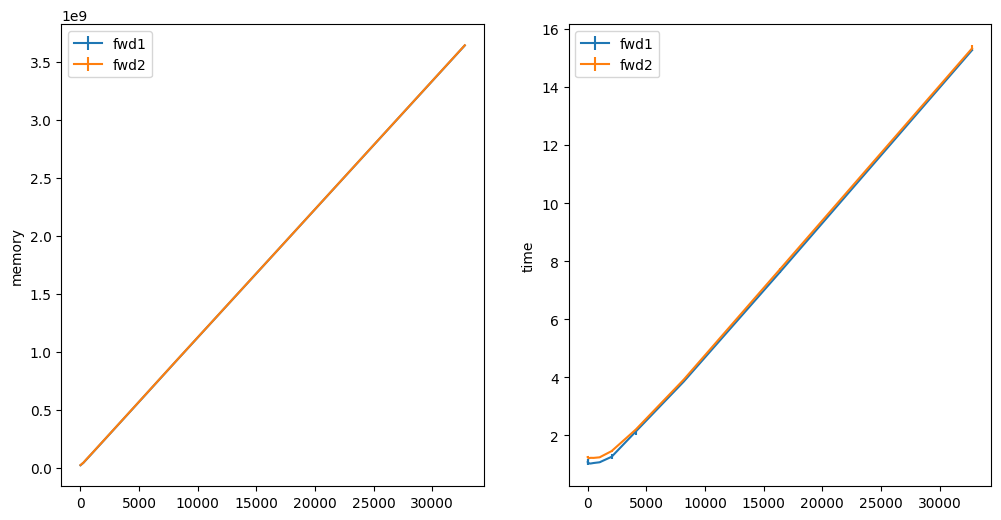

In [18]:
# plot, for each column compute mean and std error
import matplotlib.pyplot as plt

# create a figure with two subplots
fig, axs = plt.subplots(1, 2, figsize=(12, 6))
for i, mode in enumerate(['memory', 'time']):
    for func_name in results[mode]:
        df = results[mode][func_name]
        mean = df.mean()
        std = df.std()
        axs[i].errorbar(mean.index, mean, yerr = std, label = func_name)
        axs[i].legend()
        axs[i].set_ylabel(mode)



# Test on CopyGrad

In [22]:
import torch

# set seed
torch.manual_seed(0)
z = torch.randn(3, requires_grad=True)
x = z ** 2
y = x.clone()
l = (y**2).sum()
l.backward()


z.grad

tensor([ 14.6374,  -0.1011, -41.3719])

In [23]:
import torch

# set seed
torch.manual_seed(0)
z = torch.randn(3, requires_grad=True)
x = z ** 2
l = (x**2).sum()
l.backward()

z.grad

tensor([ 14.6374,  -0.1011, -41.3719])

In [12]:
import torch

x = torch.randn(5, 5, requires_grad=True)
y = x.view(25)  # reshaping x to a different shape
z = y.sum()
z.backward()

print(x.grad)  # This will show gradients properly propagated back through y to x.
print(y.grad_fn)  # This will display <UnsafeViewBackward>


tensor([[1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1.]])
